In [65]:
import rasterio
import rasterio.plot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import rioxarray as xr
import cv2 as cv
import matplotlib
import glob
import pandas as pd
from datetime import timedelta
import os

In [269]:
######## The function below reads the tiff files and creates/assign variables

### Function Inputs
## year: year of the data file
## month: month of the data file
## day: day of the data file
## hour: hour of the data file
## minute_start: minute of the first data file 
## minute_end: minute of the last data file
## new_hour: set to false however when true will add one to the hour to the end date range value

### Function work flow
## a date range is defined based on the inputs of the user
## glob is used to create a file list of the files in order based off of linux command ls -ltr 
## a date range of forecast times is created by adding 30 minutes to date range of data files
## tif files are read and variables are assigned to each individual file
## data from solona obs is read and is sliced using forecast date range



def read_and_create_data(year=None,month=None,day=None,hour=None,minute_start=None,minute_end=None,new_hour=False):
    file_name = '/home/tyler/cloud_advection/operational/erebos_grid_{0}-{1}-{2}*'.format(year,month,day)

    if new_hour == False:
        start = '{0}-{1}-{2} {3}:{4}:00'.format(year,month,day,hour,minute_start)
        end = '{0}-{1}-{2} {3}:{4}:00'.format(year,month,day,hour,minute_end)
    if new_hour == True:
        hourz = int(hour)
        hour1 = hourz + 1
        start = '{0}-{1}-{2} {3}:{4}:00'.format(year,month,day,hour,minute_start)
        end = '{0}-{1}-{2} {3}:{4}:00'.format(year,month,day,hour1,minute_end)
    
    date_range1 = pd.date_range(start=start, end=end, freq='5T')
    date_range = date_range1.to_pydatetime()
    
    forecast_times = date_range + timedelta(minutes=30)
    
    filelist = sorted(glob.glob(file_name),key=os.path.getmtime)


    tiff1 = rasterio.open(filelist[0])
    tiff2 = rasterio.open(filelist[1])
    tiff3 = rasterio.open(filelist[2])
    tiff4 = rasterio.open(filelist[3])
    tiff5 = rasterio.open(filelist[4])
    tiff6 = rasterio.open(filelist[5])
    tiff7 = rasterio.open(filelist[6])



    file1 = tiff1.read(1)
    file2 = tiff2.read(1)
    file3 = tiff3.read(1)
    file4 = tiff4.read(1)
    file5 = tiff5.read(1)
    file6 = tiff6.read(1)
    file7 = tiff7.read(1)


    col_names = ['DATE','GHI']
    obs = pd.read_csv('ghi_20200301_20200901.csv', parse_dates = [0], skiprows = 1, names=col_names)
    obs['DATE'] = pd.to_datetime(obs['DATE'])
    obs = obs.set_index('DATE')
    date_index2 = pd.date_range(obs.index[2],obs.index[-4], freq='5min')
    obs = obs.reindex(date_index2)
    
    obs1 = obs[start:end]
    obs1 = np.asarray(obs1).squeeze()
    
    return file1,file2,file3,file4,file5,file6,file7,date_range,forecast_times,obs1



In [270]:
file1,file2,file3,file4,file5,file6,file7,date_range,forecast_times,obs1 = read_and_create_data(year='2020',month='03',day='01',hour='18',minute_start='42',minute_end='7',new_hour=True)

/home/tyler/miniconda3/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [272]:
######## The following function calculates the optical flow using the data files from the previous function

### function inputs:
## a: first tiff file
## b: second tiff file
## c: third tiff file
## d: fourth tiff file
## e: fifth tiff file
## f: sixth tiff file
## g: seventh tiff file
## change_weights: default is false but if set to true the weights of the averaging function can be changed
## w1: user controlled weight of first optical flow vectors
## w2: user controlled weight of second optical flow vectors
## w3: user controlled weight of third optical flow vectors
## w4: user controlled weight of fourth optical flow vectors
## w5: user controlled weight of fifth optical flow vectors
## w6: user controlled weight of sixth optical flow vectors

### Function workflow:
## the opencv optical flow (farneback method) function is used to caluclate the optical flow between two synchronous files
## numpy average function creates a weighted average of all 6 optical flow vectors




def calc_optical_flow(a,b,c,d,e,f,g,change_weights=False,w1=None,w2=None,w3=None,w4=None,w5=None,w6=None):


    flow1 = cv.calcOpticalFlowFarneback(a, b, flow=None, pyr_scale=0.5, levels=3, winsize=15, iterations=3, 
    poly_n=5, poly_sigma=1.2,flags=None)


    flow2 = cv.calcOpticalFlowFarneback(b, c, flow=None, pyr_scale=0.5, levels=3, winsize=15, iterations=3, 
    poly_n=5, poly_sigma=1.2,flags=None)



    flow3 = cv.calcOpticalFlowFarneback(c, d, flow=None, pyr_scale=0.5, levels=3, winsize=15, iterations=3, 
    poly_n=5, poly_sigma=1.2,flags=None)


    flow4 = cv.calcOpticalFlowFarneback(d, e, flow=None, pyr_scale=0.5, levels=3, winsize=15, iterations=3, 
    poly_n=5, poly_sigma=1.2,flags=None)


    flow5 = cv.calcOpticalFlowFarneback(e, f, flow=None, pyr_scale=0.5, levels=3, winsize=15, iterations=3, 
    poly_n=5, poly_sigma=1.2,flags=None)


    flow6 = cv.calcOpticalFlowFarneback(f, g, flow=None, pyr_scale=0.5, levels=3, winsize=15, iterations=3, 
    poly_n=5, poly_sigma=1.2,flags=None)


    
    array = np.array([flow1,flow2,flow3,flow4,flow5,flow6])

    if change_weights == False:
    
        flow = np.average(array, axis=0, weights=(0.01,0.02,0.05,0.075,0.1,0.745)).astype(np.float32)
    
    if change_weights == True:
        
        flow = np.average(array, axis=0, weights=(w1,w2,w3,w4,w5,w6)).astype(np.float32)
    
    return flow




In [ ]:
flow = calc_optical_flow(file1,file2,file3,file4,file5,file6,file7)

flow1 = calc_optical_flow(file1,file2,file3,file4,file5,file6,file7,change_weights=True,w1=0.01,w2=0.02,w3=0.03,w4=0.05,w5=0.09,w6=0.80)

In [254]:
####### The following function generates the u and v components of the optical flow vector calculated in previous function

### Function inputs:
## flow_name: simply include the name of the optical flow variable

### Function workflow:
## the u and v components are extracted and appended into separate arrays using a double for loop


def flow_vectors(flow_name):
    
    u = []
    v = []

    for i in range(len(flow_name)):
        for j in range(len(flow_name)):
            u.append(flow_name[i,j,0])
            v.append(flow_name[i,j,1])

    return u,v


In [255]:
def remap_image(image: np.ndarray, flow: np.ndarray) -> np.ndarray:
    """Takes an image and warps it forwards in time according to the flow field.
    
    Args:
        image: The grayscale image to warp.
        flow: A 3D array.  The first two dimensions must be the same size as the first two
            dimensions of the image.  The third dimension represented the x and y displacement.
            
    Returns:  Warped image.
    """
    # Adapted from https://github.com/opencv/opencv/issues/11068
    height, width = flow.shape[:2]
    remap = -flow.copy()
    remap[:,:, 0] += np.arange(width)  # x map
    remap[:,:, 1] += np.arange(height)[:, np.newaxis]  # y map
    return cv.remap(src=image, map1=remap, map2=None, interpolation=cv.INTER_NEAREST, borderMode=cv.BORDER_REPLICATE)

In [260]:
rm1 = remap_image(file7,flow)
rm2 = remap_image(rm1,flow)
rm3 = remap_image(rm2,flow)
rm4 = remap_image(rm3,flow)
rm5 = remap_image(rm4,flow)
rm6 = remap_image(rm5,flow)

remap_array = np.array([rm1,rm2,rm3,rm4,rm5,rm6])

797.6

In [261]:
####### The following function generates two different types of plots for the optical flow vectors and remapped forecasted ghi values

### Function inputs:
## option1: default is false but if set to true the first plotting option will be used
## option2: default is false but if set to true the second plotting option will be used
## file_r: name of file/variable being plotted for the ghi values (optical flow vectors will automatically plot)
## current_time: the current forecast time being plotted
## date_init: the model initialization date or fcst hour 0
## fcst_interval: the interval of the forecast (e.g. how many five minute interval since the model initialization time)
## fcst_val: the forecasted ghi value at the point of interest or center point
## obs_val: the observed value at the point of interest or center point 

### Workflow:
## option1:
## in option 1 the flow vector quivers and forecasted ghi values are plotted on same plot
## flow vector quivers (arrows) are first plotted
## next the gridded ghi values are plotted in color as well as values
## a lime green box in the center is the location of the point of interest
## forecasted and observed ghi values are displayed at the bottom

## option2:
## in option 2 the flow vector quivers and forecasted ghi values are plotted on diiferent plots
## flow vector quivers (arrows) are first plotted on the left plot
## next the gridded ghi values are plotted in color as well as values on the right plot
## a lime green box in the center is the location of the point of interest
## forecasted and observed ghi values are displayed at the bottom



def plot_func(option1=False,option2=False,file_r=None,current_time=None,date_init=None,fcst_interval=None, fcst_val=None,obs_val=None):   
    
    if option1 == True:
        x_coords = np.arange(0,9,1)
        y_coords = np.arange(0,9,1)

        x,y = np.meshgrid(x_coords,y_coords)

        u,v = flow_vectors(flow)

        fig = plt.figure(figsize=(12,10), tight_layout = False)

        gs = fig.add_gridspec(1, 1)

        ax1 = fig.add_subplot(gs[0,0])
        ax1.quiver(x,y,u,v, color = 'red')
        
        ax1.set_ylabel('km from origin', fontsize=14)
        ax1.set_xlabel('km from origin', fontsize=14)
        
        
        rect = plt.Rectangle((4-.5, 4-.5), 1,1, fill=False, color="limegreen", linewidth=7)
        ax1.add_patch(rect)
        

        ax1.matshow(file_r, cmap=plt.cm.Blues)
        
        ax1.set_xticklabels(['-5','-4','-3','-2','-1','0','1','2','3','4'])
        ax1.set_yticklabels(['5','4','3','2','1','0','-1','-2','-3','-4'])
        
        ax1.xaxis.set_tick_params(labelbottom=True)
        ax1.xaxis.set_tick_params(labeltop=False)
        
        xloc = 0.50
        yloc = 1.10
        
        plt.suptitle('GHI Optical Flow Model\n\nForecast Run: {0}\nForecast Interval: {1}\nValid Time: {2}'.format(date_init,fcst_interval,current_time),x=xloc,y=yloc,fontsize=18)
        ax1.set_title('GHI Forecast Values and Optical Flow Vectors', loc='center',fontsize=14)

        for i in range(9):
            for j in range(9):
                c = round(file_r[j,i])
                txt = ax1.text(i, j, str(c), va='center', ha='center', fontsize=14)
                
                
        plt.text(2.5,10,'Forecast GHI: {} W/m^2'.format(fcst_val),fontsize=18)
        plt.text(2.5,10.5,'Observed GHI: {}W/m^2'.format(obs_val),fontsize=18)
     
    
    
                
    if option2 == True:
        x_coords = np.arange(-4,5,1)
        y_coords = np.arange(-4,5,1)

        x,y = np.meshgrid(x_coords,y_coords)

        u,v = flow_vectors(flow)

        fig = plt.figure(figsize=(15,10), tight_layout = False)

        gs = fig.add_gridspec(14, 2)

        ax1 = fig.add_subplot(gs[2:12,0])
        ax1.quiver(x,y,u,v, color = 'blue')
        
        ax1.set_ylabel('km from origin', fontsize=14)
        ax1.set_xlabel('km from origin', fontsize=14)
        
        ax1.set_title('Optical Flow Vectors', loc='center',fontsize=14)

        rect = plt.Rectangle((0-.5, 0-.5), 1,1, fill=False, color="limegreen", linewidth=3)
        ax1.add_patch(rect)
        
        ax1.grid()
        ax2 = fig.add_subplot(gs[0:14,1])

        ax2.matshow(file_r, cmap=plt.cm.Blues)
        
        rect1 = plt.Rectangle((4-.5, 4-.5), 1,1, fill=False, color="limegreen", linewidth=5)
        ax2.add_patch(rect1)
        
        ax2.set_xticklabels(['-5','-4','-3','-2','-1','0','1','2','3','4'])
        ax2.set_yticklabels(['5','4','3','2','1','0','-1','-2','-3','-4'])
        
        ax2.set_ylabel('km from origin', fontsize=14)
        ax2.set_xlabel('km from origin', fontsize=14)
        
        ax2.xaxis.set_tick_params(labelbottom=True)
        ax2.xaxis.set_tick_params(labeltop=False)
        
        xloc = 0.50
        yloc = 0.94
        
        plt.suptitle('GHI Optical Flow Model\n\nForecast Run: {0}\nForecast Interval: {1}\nValid Time: {2}'.format(date_init,fcst_interval,current_time),x=xloc,y=yloc,fontsize=18)
        ax2.set_title('GHI Forecast Values', loc='center',fontsize=14)

        for i in range(9):
            for j in range(9):
                c = round(file_r[j,i])
                txt = ax2.text(i, j, str(c), va='center', ha='center')
                
                
        plt.text(-3,10,'Forecast GHI: {} W/m^2'.format(fcst_val),fontsize=18)
        plt.text(-3,10.5,'Observed GHI: {} W/m^2'.format(obs_val),fontsize=18)
        
                




In [267]:
###### The following function will loop through all the forecast time and plots for each forecast time

### Function inputs:
## plot_option1: set to false but when true will plot option 1 from the plotting function
## plot_option2: set to false but when true will plot option 2 from the plotting function

### Workflow:
## depending on the input, plots of all six forecast times will be returned



def loop_plots(plot_option1=False,plot_option2=False):
    if plot_option1 == True:
        for i in range(len(remap_array)):
            plot_func(option1=True,file_r=remap_array[i],current_time=date_range[i],date_init = date_range[-1],fcst_interval = i+1,fcst_val=round(remap_array[i][4,4]),obs_val=round(obs1[i]))
            
    if plot_option2 == True:
        for i in range(len(remap_array)):
            plot_func(option2=True,file_r=remap_array[i],current_time=date_range[i],date_init = date_range[-1],fcst_interval = i+1,fcst_val=round(remap_array[i][4,4]),obs_val=round(obs1[i]))

/tmp/ipykernel_77668/3868695032.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['-5','-4','-3','-2','-1','0','1','2','3','4'])
/tmp/ipykernel_77668/3868695032.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['5','4','3','2','1','0','-1','-2','-3','-4'])


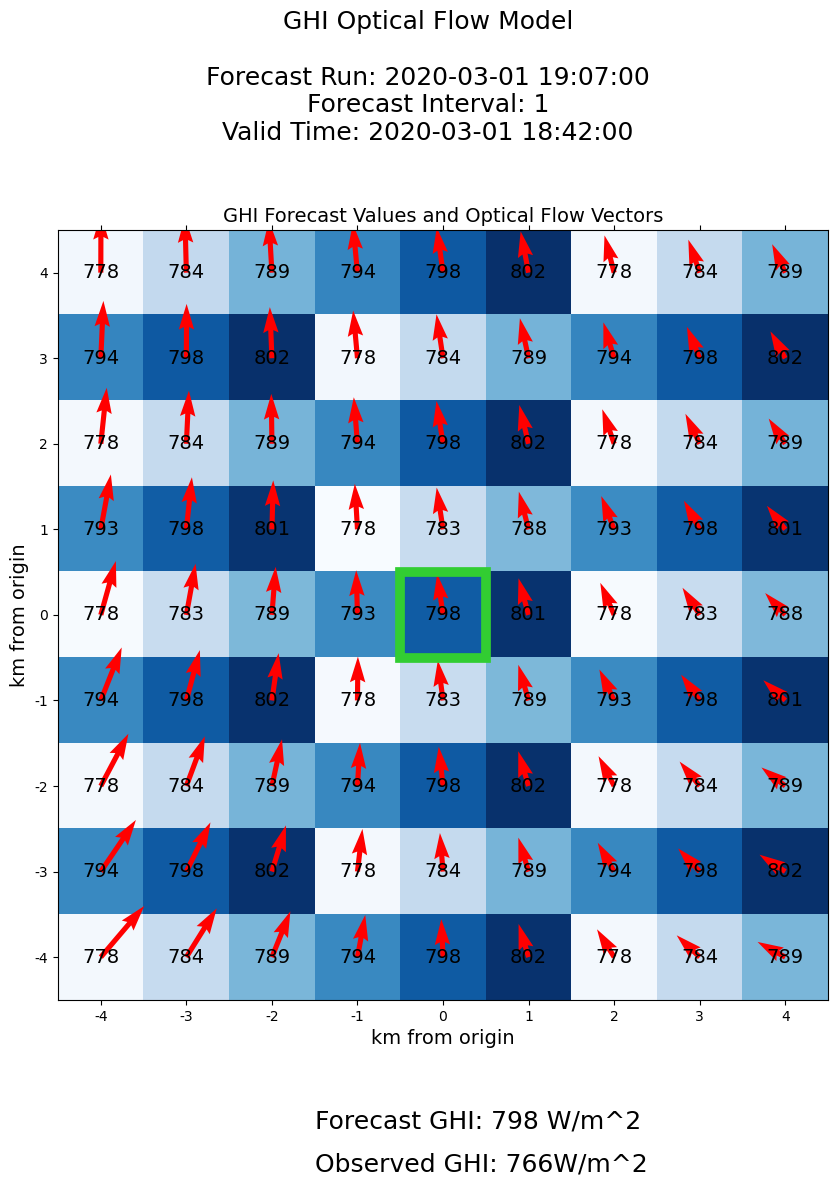

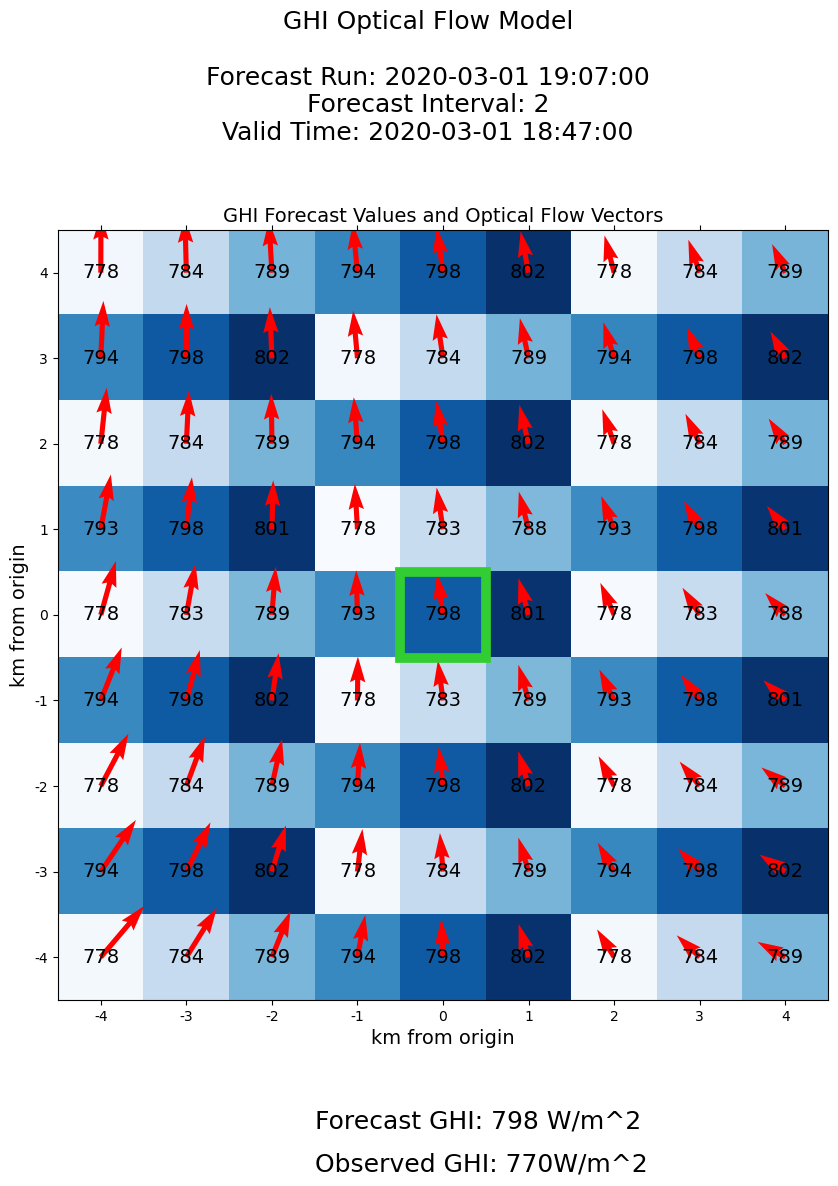

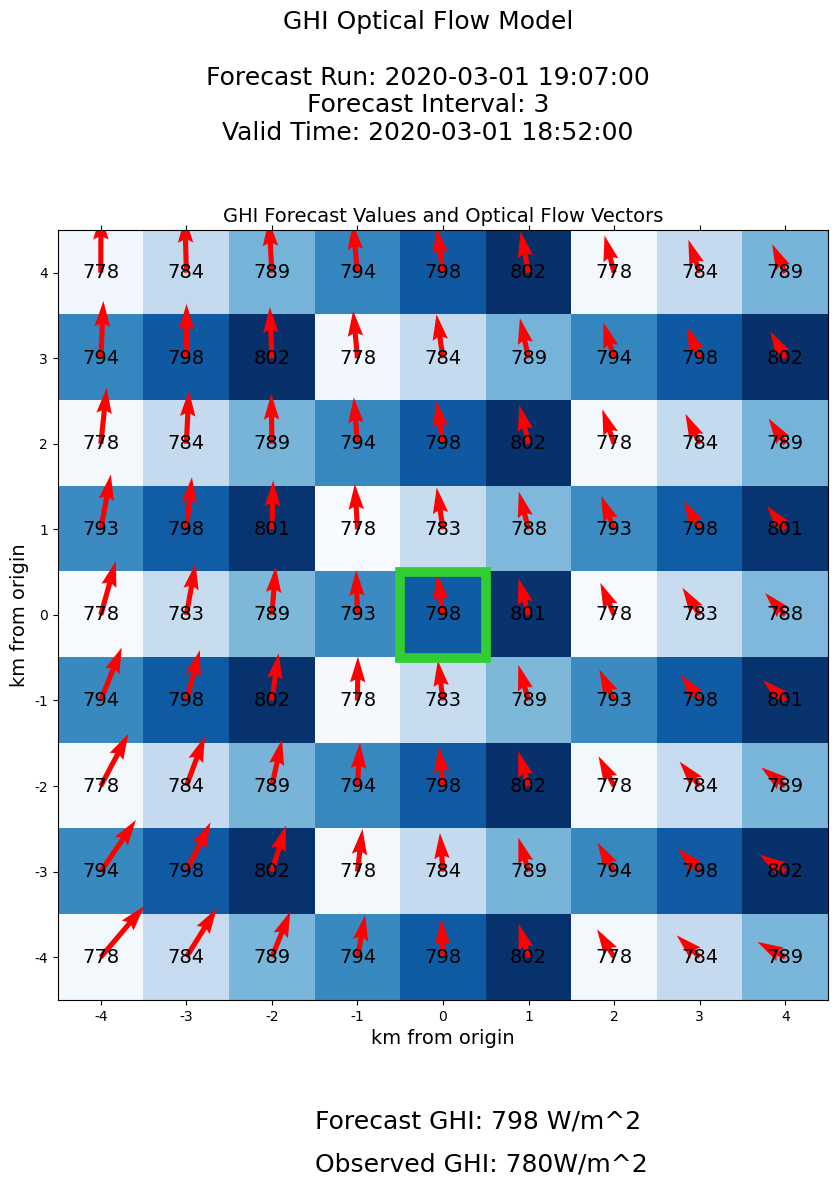

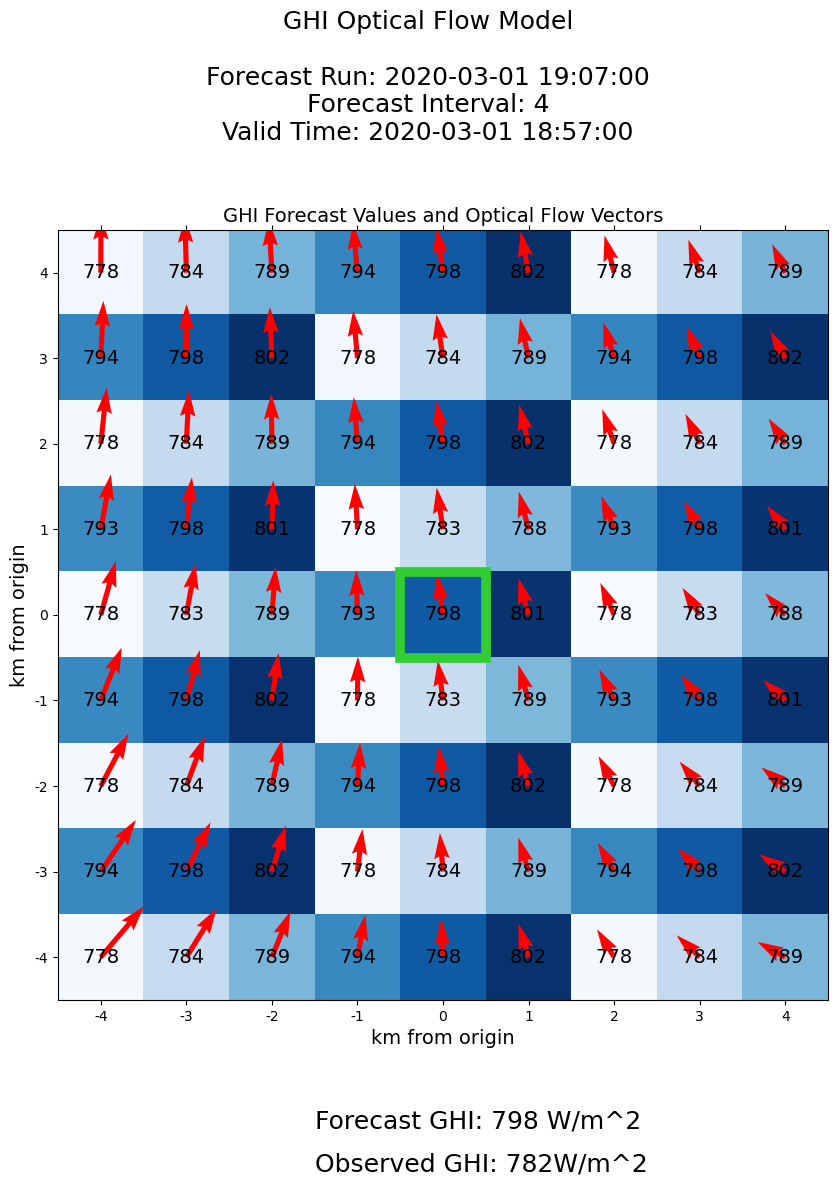

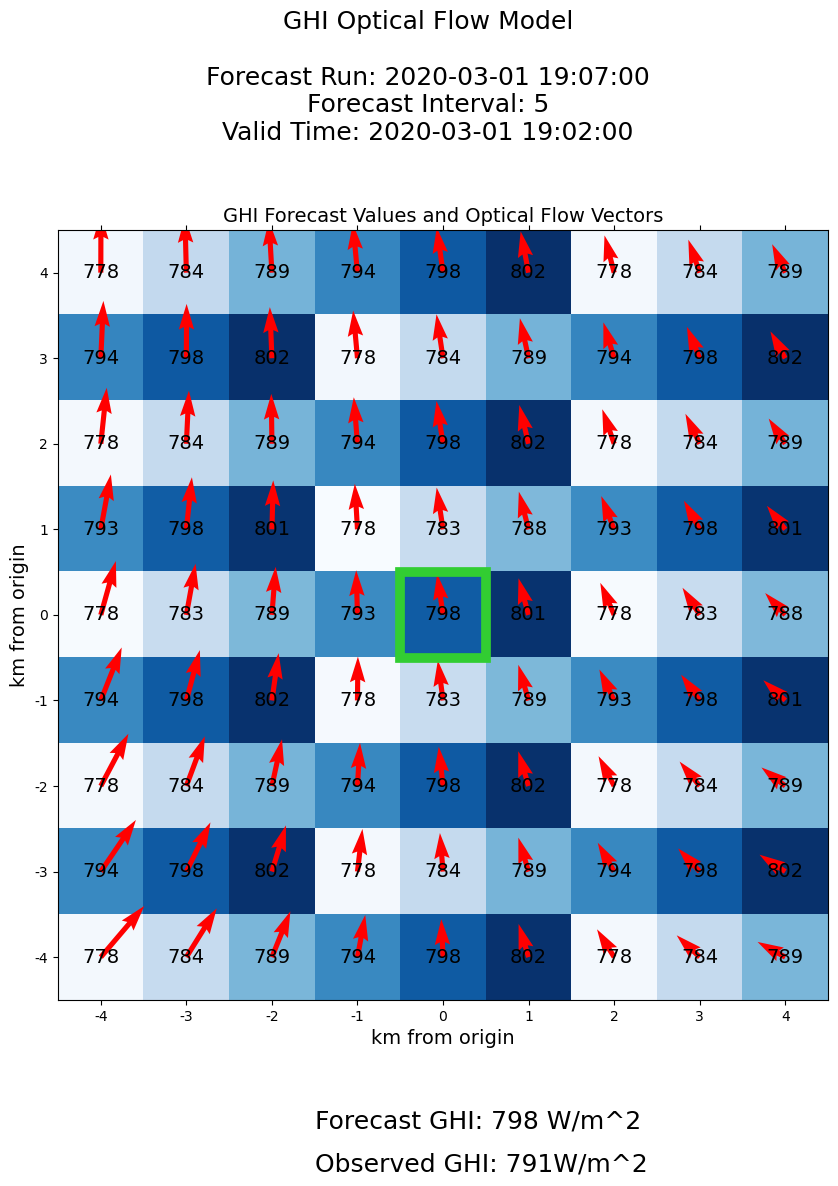

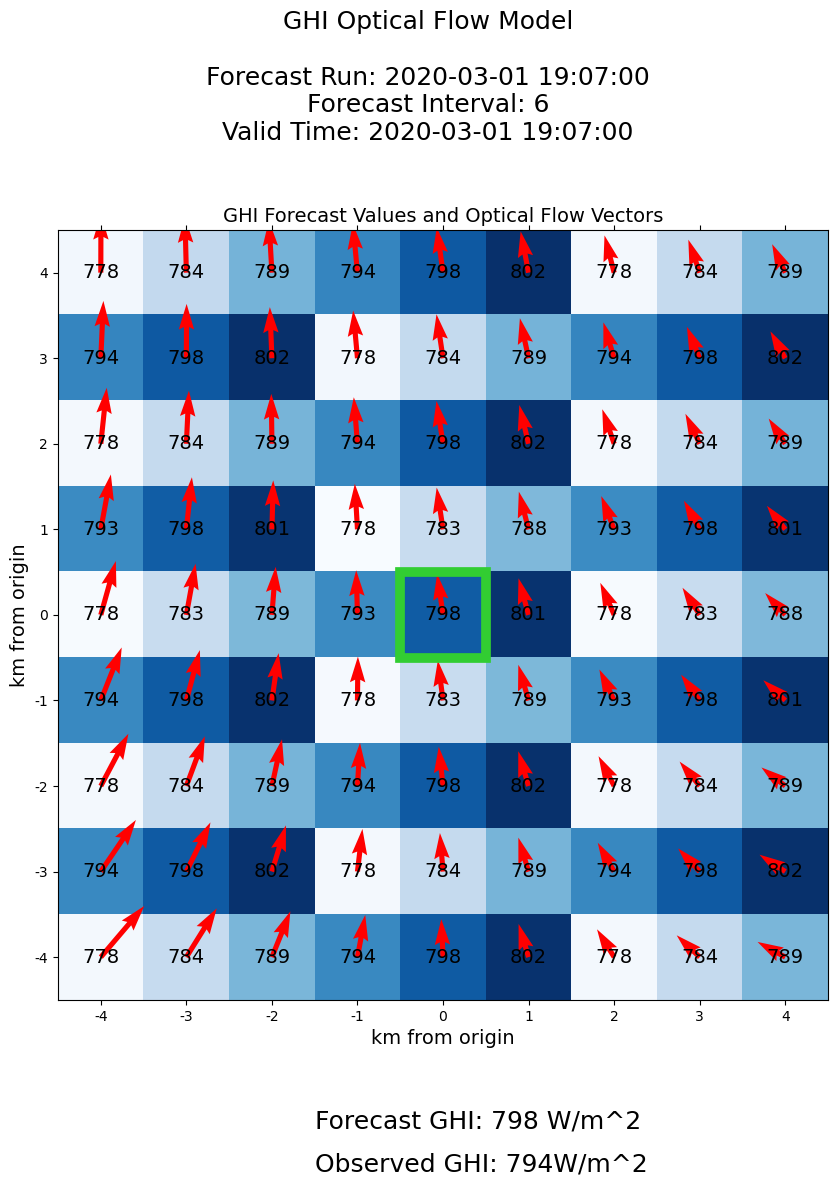

In [265]:
loop_plots(plot_option1=True)

/tmp/ipykernel_77668/3868695032.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['-5','-4','-3','-2','-1','0','1','2','3','4'])
/tmp/ipykernel_77668/3868695032.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['5','4','3','2','1','0','-1','-2','-3','-4'])


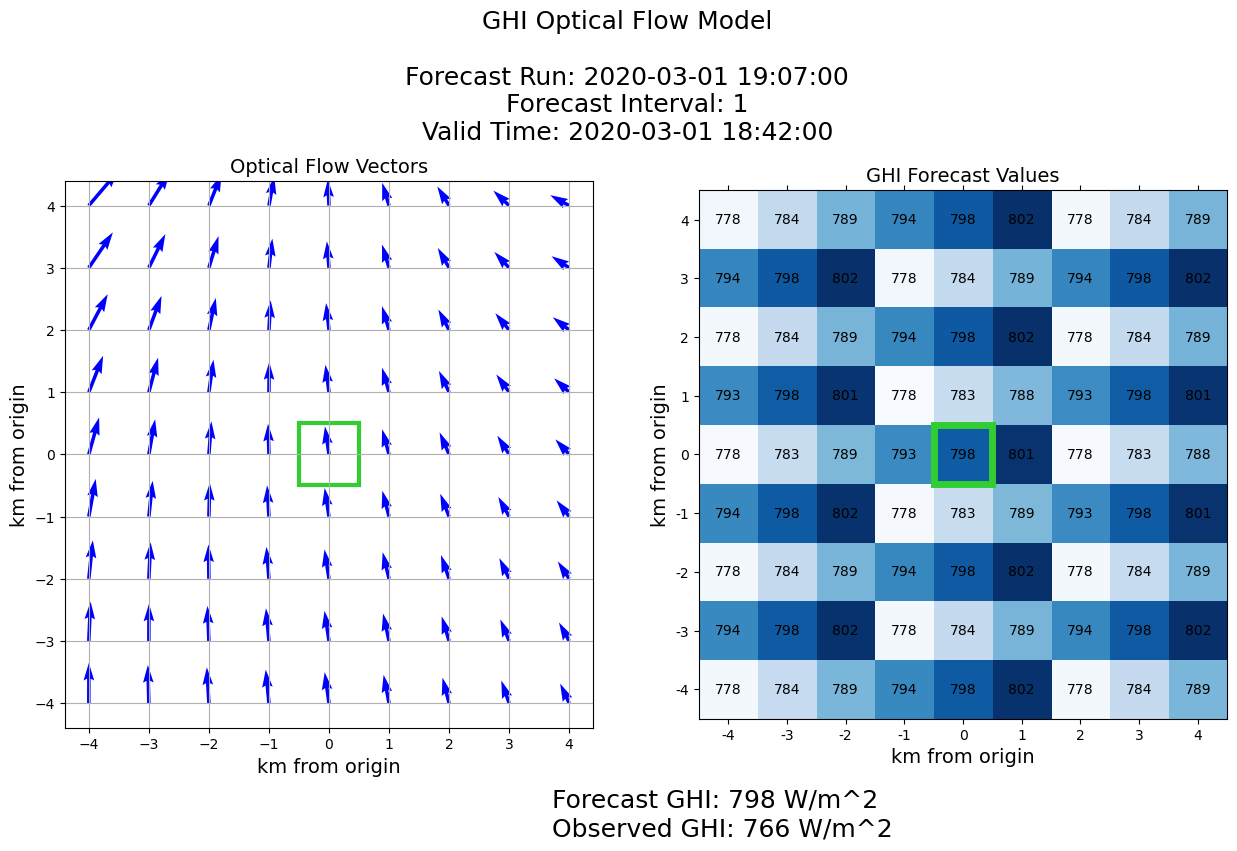

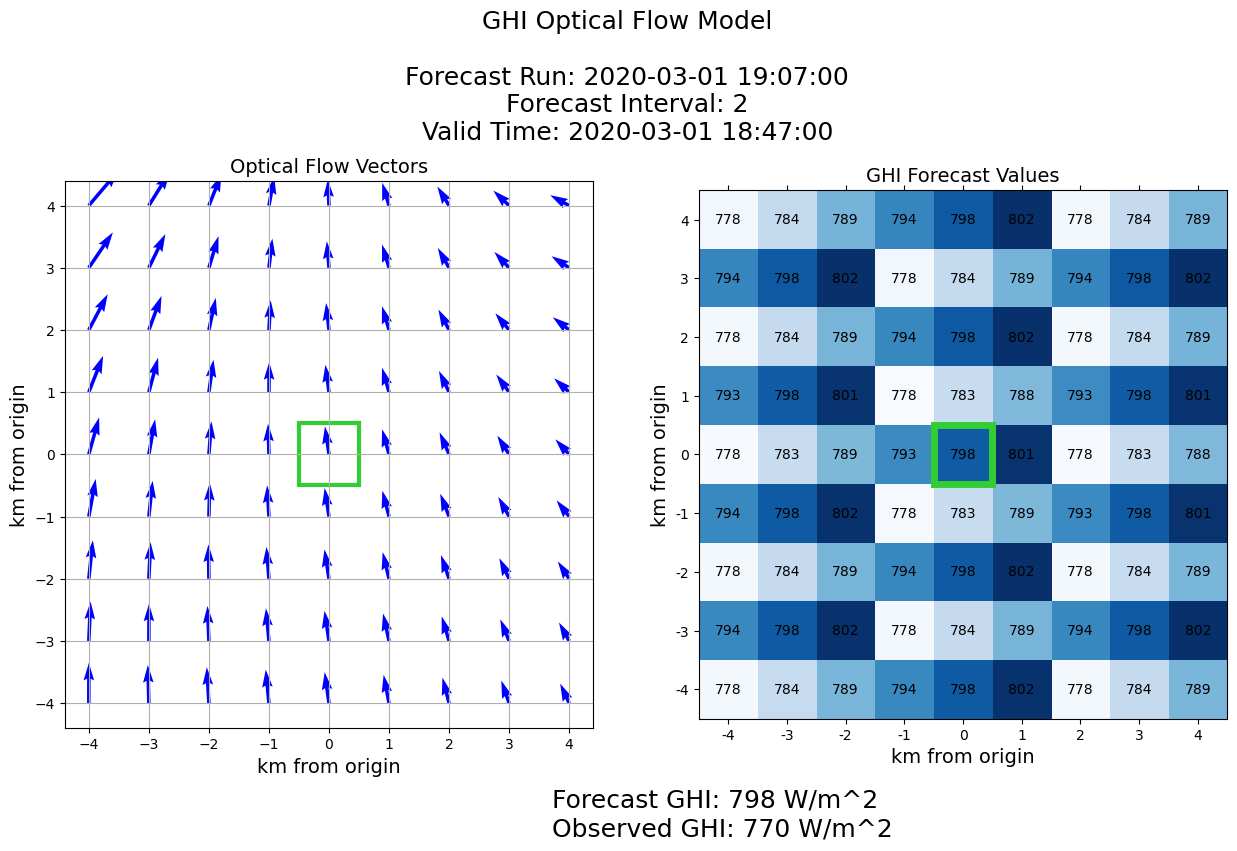

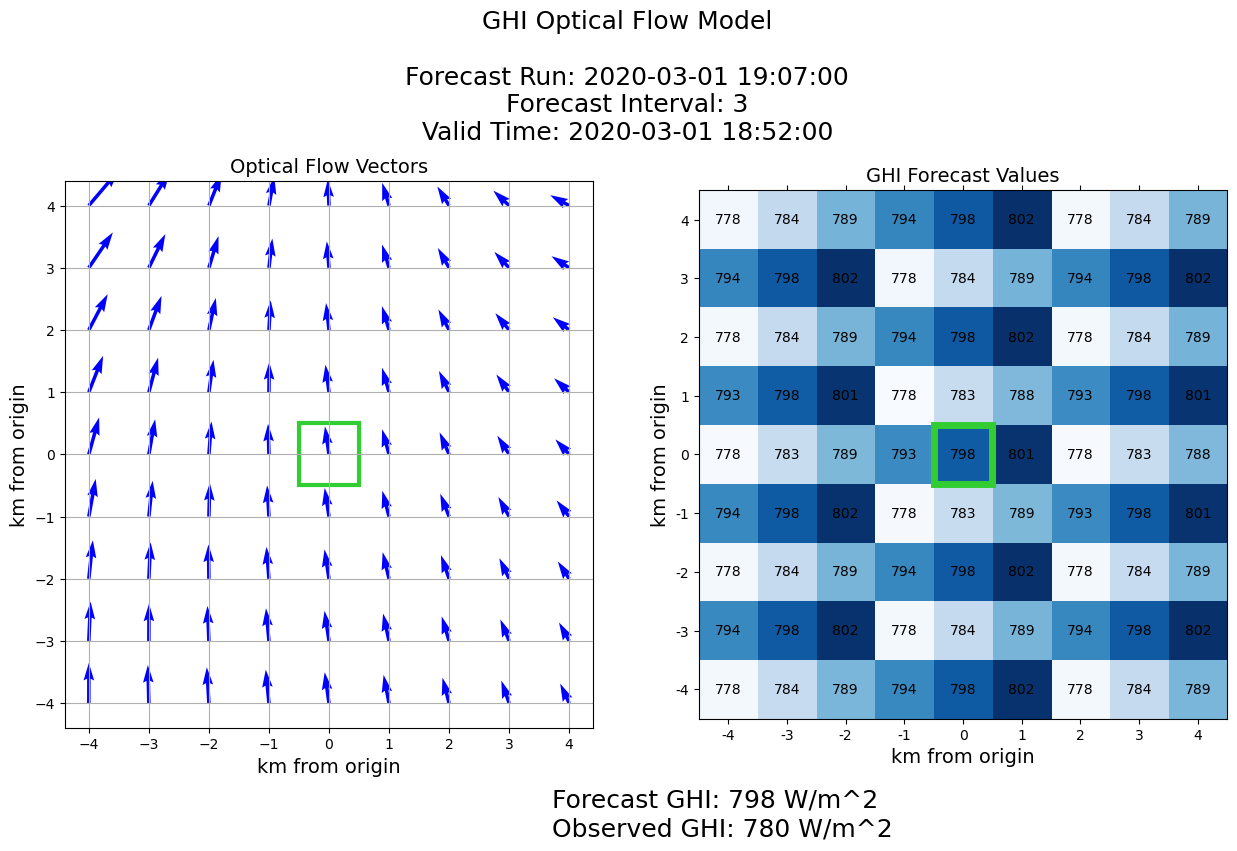

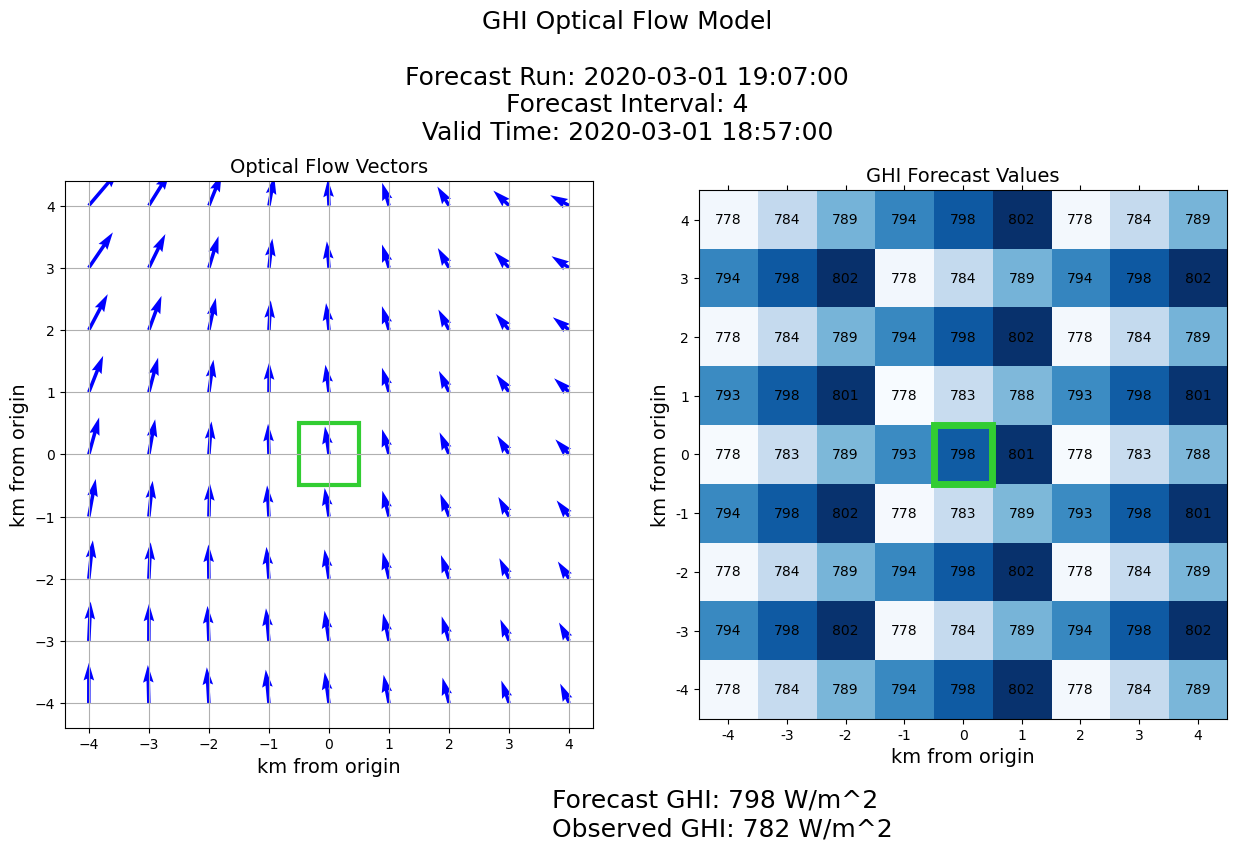

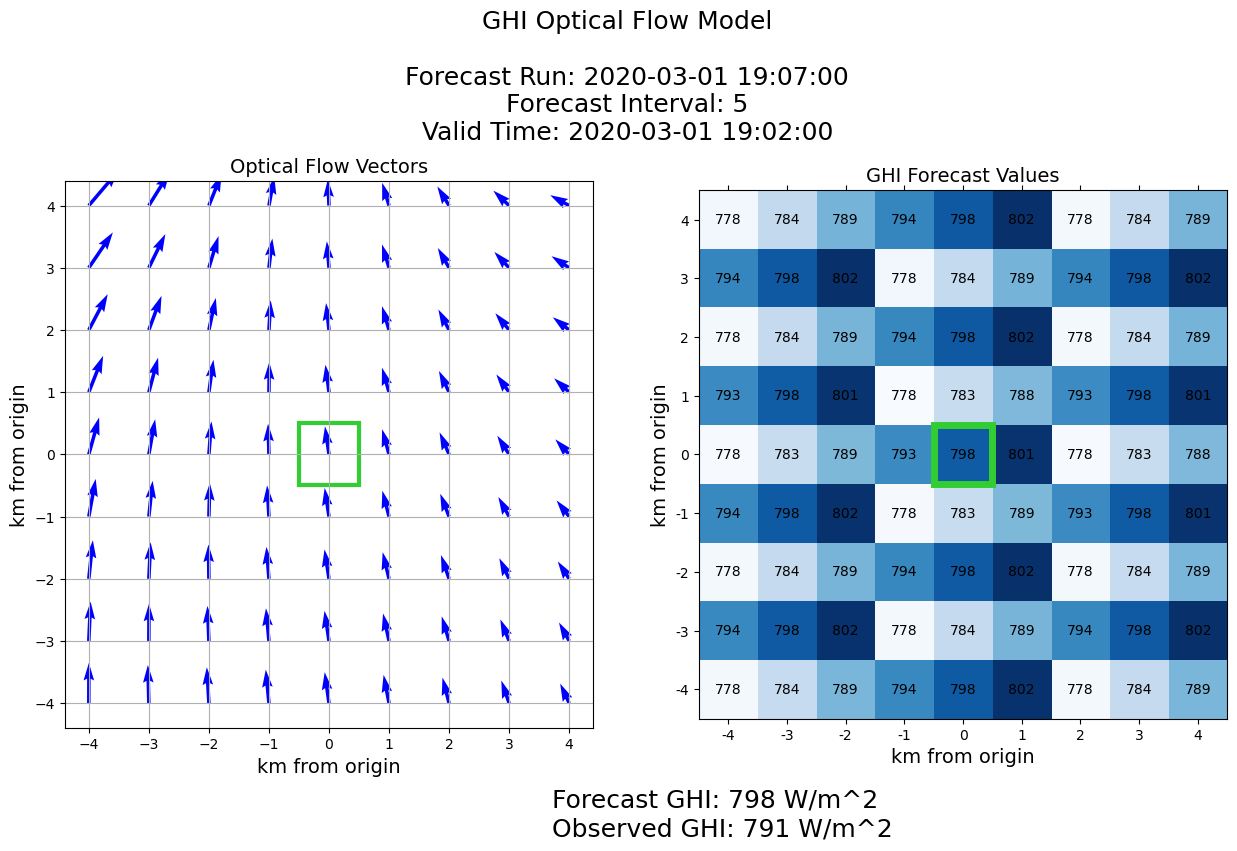

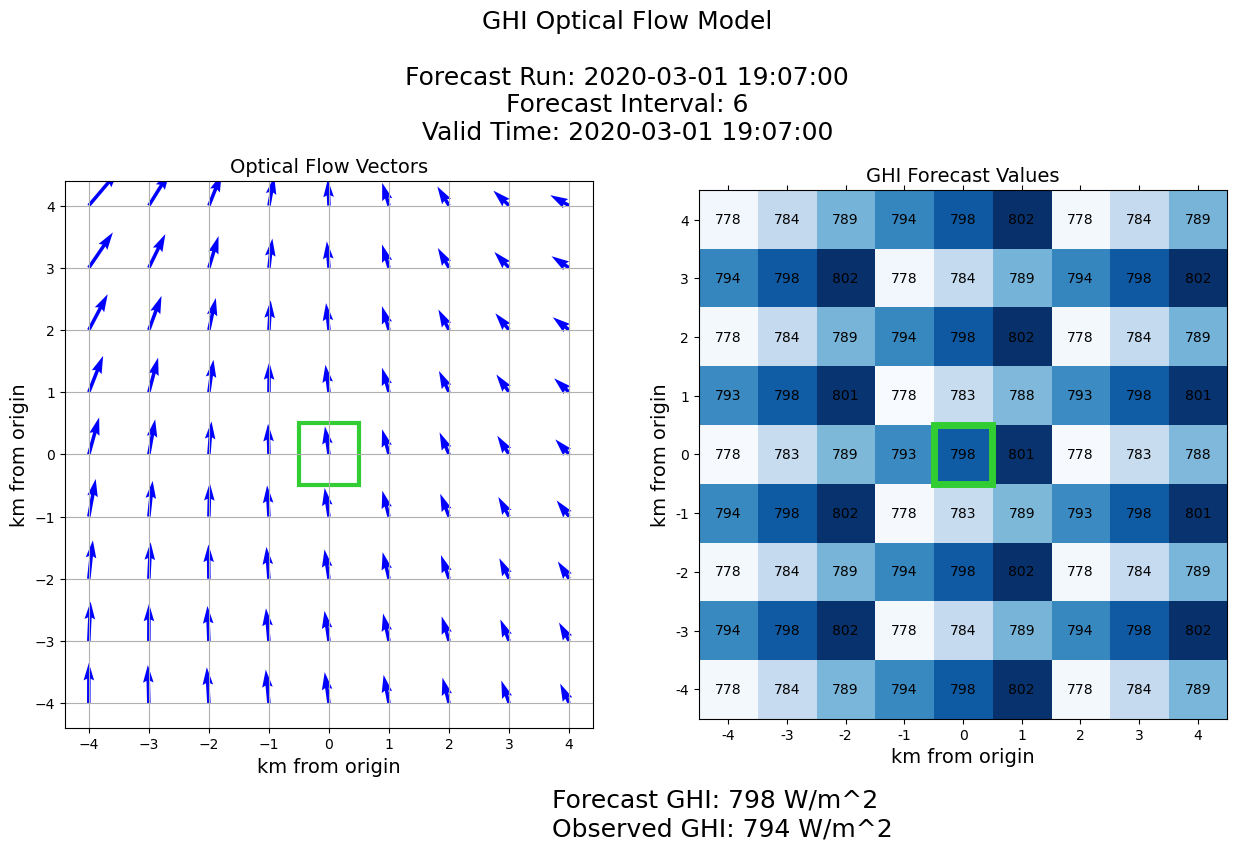

In [268]:
loop_plots(plot_option2=True)